[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] Start training from score 8.202201


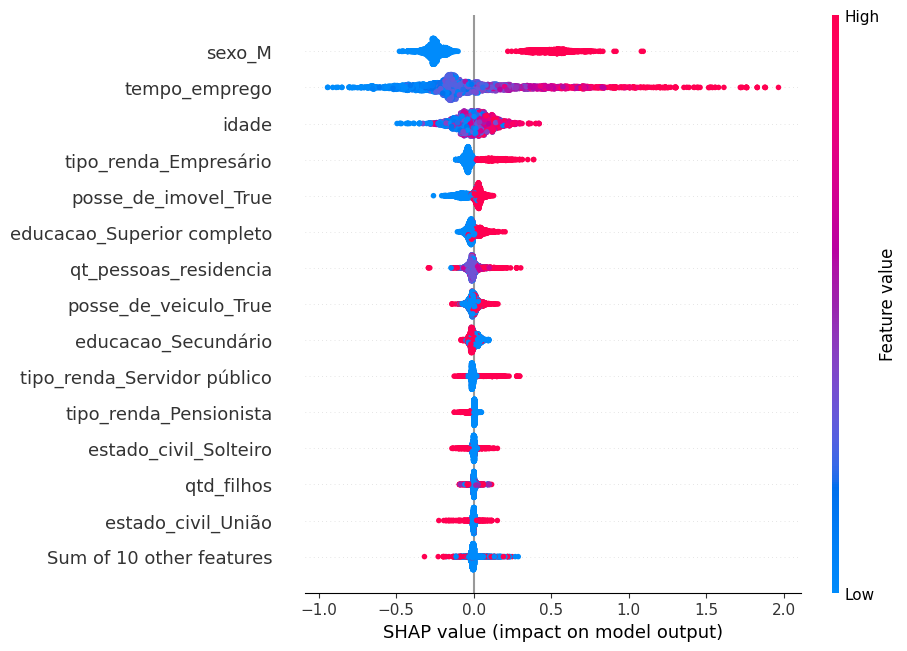

MAE: 2775.40
RMSE: 5419.87


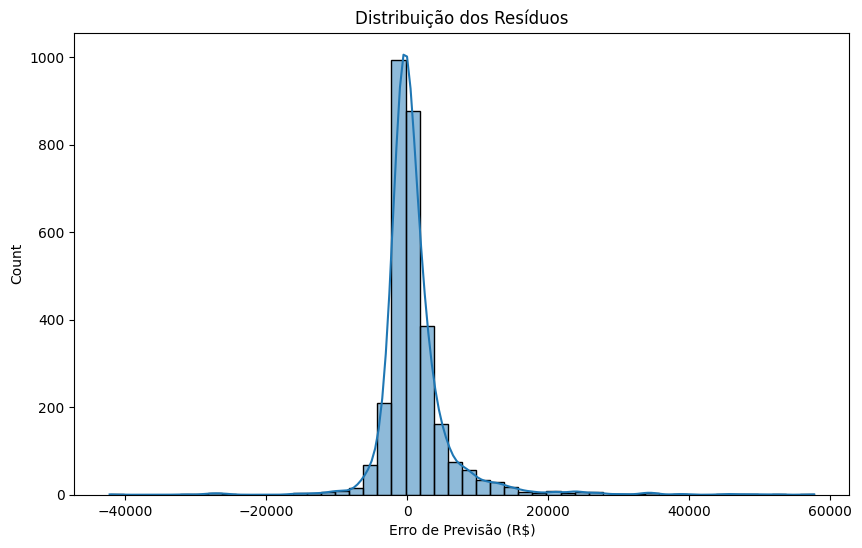

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
import shap

# Carregando os dados
df = pd.read_csv("./test/input/previsao_de_renda.csv")

# Removendo colunas não úteis
X = df.drop(columns=['Unnamed: 0', 'id_cliente', 'data_ref', 'renda'])
y = df['renda']

# Transformação logarítmica na variável target
y_log = np.log1p(y)

# Separando tipos de colunas
numeric_features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos']
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']



# Define imputers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Pré-processador
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

numeric_feature_names = numeric_features

# Pipeline de modelagem
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, subsample=0.8, random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Treinamento
pipeline.fit(X_train, y_train)

numeric_feature_names = numeric_features
preprocessor2 = pipeline.named_steps['preprocessor']
# Get transformed numeric feature names (unchanged)
numeric_feature_names = numeric_features

# Get transformed categorical feature names (after one-hot encoding)
ohe = preprocessor2.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine all feature names in the order used by the model
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Get feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(categorical_feature_names)

# Compute SHAP values
explainer = shap.Explainer(pipeline.named_steps['model'])
X_transformed = preprocessor.transform(X_test)
shap_values = explainer(X_transformed)

# Inject correct feature names into the SHAP Explanation object
shap_values.feature_names = all_feature_names

# Plot
shap.plots.beeswarm(shap_values, max_display=15)

# Predição e avaliação
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



# Visualização da distribuição dos resíduos
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro de Previsão (R$)")
plt.show()

O processo de treinamento foi realizado utilizando o LightGBM, uma estrutura de gradient boosting altamente otimizada para grandes volumes de dados. O conjunto de treinamento consistiu em 12.000 pontos de dados e 22 características. Com base nas informações iniciais, o modelo utiliza multi-threading por linha, o que é automaticamente selecionado pelo LightGBM com base no custo da análise de sobrecarga (0.000384 segundos). Esse processo reduz significativamente o tempo de treinamento em comparação com outros métodos, mas vale destacar que o tempo de sobrecarga é negligível e não afeta o desempenho geral.

O score inicial de treinamento do modelo foi 8.202201, o que pode indicar o valor inicial de previsão antes da otimização. Um ponto importante é o valor de Total Bins, que é 356. Isso representa o número de intervalos discretizados que o modelo usa para dividir características contínuas. Essa abordagem é crucial para a eficiência do LightGBM, pois permite decisões mais rápidas e precisas com base na estrutura dos dados.

Métricas de Avaliação:
Erro Absoluto Médio (MAE): O MAE foi de 2775,40, o que indica que, em média, as previsões do modelo se desviam dos valores reais em cerca de 2775. Essa métrica fornece uma noção intuitiva da magnitude dos erros nas previsões do modelo, e, dado a escala dos dados, esse valor pode ser aceitável ou não, dependendo do contexto de negócio e da faixa de valores da variável alvo.

Erro Quadrático Médio (RMSE): O RMSE foi de 5419,87, o que fornece uma medida mais sensível para erros maiores, penalizando previsões com maiores desvios de forma mais acentuada do que o MAE. O RMSE é significativamente mais alto que o MAE, o que sugere que existem alguns outliers (valores extremos) nos dados que o modelo está tendo dificuldades em prever corretamente.

Análises e Próximos Passos:
Desempenho do Modelo: A diferença considerável entre o MAE e o RMSE indica a presença de possíveis outliers ou uma distribuição de erros assimétrica. Isso sugere que, enquanto o modelo pode estar fazendo previsões razoáveis para a maioria dos dados, ele está sendo penalizado desproporcionalmente por alguns erros maiores. Esse ponto pode indicar a necessidade de uma análise mais profunda dos resíduos para identificar e tratar outliers ou anomalias nos dados.

Ajuste de Hiperparâmetros: Dada a diferença significativa entre o MAE e o RMSE, pode ser interessante realizar uma otimização de hiperparâmetros (usando técnicas como Random Search, Grid Search ou Bayesian Optimization) para tentar reduzir as tendências de overfitting ou underfitting do modelo. Ajustar parâmetros como num_leaves, learning_rate ou max_depth pode ajudar a alcançar um equilíbrio melhor entre viés e variância.

Engenharia de Características: O modelo utiliza 22 características, e seria interessante verificar se alguma interação entre características ou transformações (por exemplo, logaritmos, polinômios ou discretização de variáveis) poderia melhorar o desempenho, especialmente em relação aos outliers.

Regularização: Dado o RMSE relativamente alto, aplicar métodos de regularização, como L1/L2, pode ajudar a suavizar as previsões, reduzindo a influência de outliers e melhorando a capacidade de generalização do modelo.

Avaliação: Avaliar o modelo por meio de outras métricas, como o R² (coeficiente de determinação), também pode fornecer uma visão mais detalhada sobre a proporção da variabilidade explicada pelo modelo. Além disso, a validação cruzada em diferentes subconjuntos dos dados pode ajudar a avaliar a robustez do modelo e prevenir o overfitting.

Em resumo, embora o modelo apresente um desempenho razoável com o LightGBM, as métricas de erro observadas sugerem que há espaço para melhorias, especialmente em relação aos outliers. Uma combinação de ajuste de hiperparâmetros, engenharia de características e maior regularização pode melhorar a precisão preditiva e a capacidade de generalização do modelo.